# Adaptive RAG

Adaptive RAG dynamically chooses retrieval strategies based on query complexity. Unlike traditional RAG which always follows the same path, Adaptive RAG:
- Routes queries to appropriate data sources (vectorstore vs web search)
- Grades retrieved documents for relevance
- Transforms queries when initial retrieval fails
- Validates generated answers for hallucinations
- Loops back for refinement when needed

This implementation uses LangGraph v1.x with StateGraph, conditional edges, and structured outputs.

## Setup Environment and LLM

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [2]:
from langchain_groq import ChatGroq

# Using Groq's llama-3.3-70b model for all LLM operations
llm = ChatGroq(model="llama-3.3-70b-versatile", temperature=0)

/Users/yashsarode/Downloads/Personal Projects/Python/LangChain-LangGraph/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Build Vector Store with Wikipedia Documents

Load real documents from Wikipedia and create a vector store with ChromaDB. We'll use content about AI agents for our knowledge base.

In [3]:
from langchain_community.document_loaders import WikipediaLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma

# Load Wikipedia articles about AI agents and related topics
topics = ["Artificial intelligence", "Machine learning", "Natural language processing"]
documents = []

for topic in topics:
    loader = WikipediaLoader(query=topic, load_max_docs=2)
    documents.extend(loader.load())

print(f"Loaded {len(documents)} documents")

Loaded 6 documents


In [4]:
# Split documents into manageable chunks for better retrieval
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200
)
doc_splits = text_splitter.split_documents(documents)
print(f"Split into {len(doc_splits)} chunks")

Split into 38 chunks


In [5]:
# Create embeddings using HuggingFace's sentence transformer
# This model provides quality embeddings without requiring API calls
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-mpnet-base-v2",
    model_kwargs={"device": "cpu"},
    encode_kwargs={"normalize_embeddings": True}
)

In [6]:
# Create vector store with ChromaDB persisted locally
vectorstore = Chroma(
    collection_name="adaptive_rag",
    embedding_function=embeddings,
    persist_directory="./chroma_adaptive_rag"
)

# Add documents to the vector store
vectorstore.add_documents(doc_splits)
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

print("Vector store created and documents indexed")

Vector store created and documents indexed


## Define State Schema

State holds all data that flows through the graph. Using TypedDict provides type safety and clear documentation of data structure.

In [7]:
from typing import List
from typing_extensions import TypedDict
from langchain_core.documents import Document

class GraphState(TypedDict):
    """State schema for Adaptive RAG workflow.
    
    Attributes:
        question: User's original query
        generation: Final answer generated by LLM
        documents: Retrieved documents used as context
    """
    question: str
    generation: str
    documents: List[Document]

## Define Structured Output Schemas

Pydantic models ensure LLM outputs are properly structured for downstream processing.

In [8]:
from pydantic import BaseModel, Field
from typing import Literal

class RouteQuery(BaseModel):
    """Route query to appropriate data source."""
    datasource: Literal["vectorstore", "web_search"] = Field(
        description="Choose 'vectorstore' for AI/ML topics, 'web_search' for current events"
    )

class GradeDocuments(BaseModel):
    """Grade document relevance to question."""
    binary_score: Literal["yes", "no"] = Field(
        description="'yes' if document is relevant, 'no' otherwise"
    )

class GradeHallucinations(BaseModel):
    """Check if answer is grounded in retrieved facts."""
    binary_score: Literal["yes", "no"] = Field(
        description="'yes' if answer is grounded in facts, 'no' if hallucinated"
    )

class GradeAnswer(BaseModel):
    """Check if answer addresses the question."""
    binary_score: Literal["yes", "no"] = Field(
        description="'yes' if answer addresses question, 'no' otherwise"
    )

## Create Specialized LLM Instances

Each LLM instance is bound with a specific structured output schema for its task.

In [9]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Router LLM - decides data source
router_llm = llm.with_structured_output(RouteQuery)

route_prompt = ChatPromptTemplate.from_messages([
    ("system", """You route queries to the appropriate data source.
Use 'vectorstore' for questions about AI, machine learning, or NLP.
Use 'web_search' for current events, news, or topics outside the knowledge base."""),
    ("human", "{question}")
])

question_router = route_prompt | router_llm

# Document grader LLM
doc_grader_llm = llm.with_structured_output(GradeDocuments)

grade_prompt = ChatPromptTemplate.from_messages([
    ("system", """Grade if the document is relevant to the question.
Give a binary 'yes' or 'no' score. Use lenient grading."""),
    ("human", "Document: {document}\n\nQuestion: {question}")
])

retrieval_grader = grade_prompt | doc_grader_llm

# Hallucination grader LLM
hallucination_grader_llm = llm.with_structured_output(GradeHallucinations)

hallucination_prompt = ChatPromptTemplate.from_messages([
    ("system", """Check if the answer is grounded in the provided facts.
Give 'yes' if grounded, 'no' if it contains hallucinations."""),
    ("human", "Facts: {documents}\n\nAnswer: {generation}")
])

hallucination_grader = hallucination_prompt | hallucination_grader_llm

# Answer grader LLM
answer_grader_llm = llm.with_structured_output(GradeAnswer)

answer_prompt = ChatPromptTemplate.from_messages([
    ("system", """Check if the answer addresses the question.
Give 'yes' if it resolves the question, 'no' otherwise."""),
    ("human", "Question: {question}\n\nAnswer: {generation}")
])

answer_grader = answer_prompt | answer_grader_llm

# Generator chain - creates final answer
rag_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are an assistant answering questions using the provided context.
If you don't know, say so. Be concise and accurate."""),
    ("human", "Context: {context}\n\nQuestion: {question}")
])

rag_chain = rag_prompt | llm | StrOutputParser()

# Query rewriter
rewrite_prompt = ChatPromptTemplate.from_messages([
    ("system", """Rewrite the question to be more specific and optimized for retrieval.
Focus on the core semantic intent."""),
    ("human", "{question}")
])

question_rewriter = rewrite_prompt | llm | StrOutputParser()

## Define Graph Nodes

Each node performs a specific task and returns state updates.

In [10]:
def retrieve(state: GraphState) -> dict:
    """Retrieve documents from vector store.
    
    Uses semantic search to find relevant documents based on the question.
    """
    print("---RETRIEVE---")
    question = state["question"]
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}


def generate(state: GraphState) -> dict:
    """Generate answer using retrieved documents as context.
    
    Creates a response grounded in the retrieved information.
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    
    # Format documents as context string
    context = "\n\n".join(doc.page_content for doc in documents)
    
    generation = rag_chain.invoke({"context": context, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state: GraphState) -> dict:
    """Filter documents based on relevance to question.
    
    Each document is evaluated independently. Only relevant docs proceed.
    """
    print("---CHECK DOCUMENT RELEVANCE---")
    question = state["question"]
    documents = state["documents"]
    
    filtered_docs = []
    for doc in documents:
        score = retrieval_grader.invoke({
            "question": question,
            "document": doc.page_content
        })
        if score.binary_score == "yes":
            print("---GRADE: RELEVANT---")
            filtered_docs.append(doc)
        else:
            print("---GRADE: NOT RELEVANT---")
    
    return {"documents": filtered_docs, "question": question}


def transform_query(state: GraphState) -> dict:
    """Rewrite query to improve retrieval.
    
    Used when initial retrieval fails to find relevant documents.
    """
    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state.get("documents", [])
    
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


def web_search(state: GraphState) -> dict:
    """Perform web search for queries requiring current information.
    
    Note: This is a placeholder. In production, integrate with a search API.
    """
    print("---WEB SEARCH---")
    question = state["question"]
    
    # Placeholder for web search results
    # In production, use TavilySearchResults or similar
    web_results = Document(
        page_content=f"Web search results for: {question}. This is a placeholder."
    )
    
    return {"documents": [web_results], "question": question}

## Define Routing Logic

Conditional edges determine the next node based on current state.

In [11]:
from typing import Literal

def route_question(state: GraphState) -> Literal["web_search", "vectorstore"]:
    """Route question to web search or vectorstore.
    
    LLM decides based on question content.
    """
    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    
    if source.datasource == "web_search":
        print("---ROUTE TO WEB SEARCH---")
        return "web_search"
    else:
        print("---ROUTE TO VECTORSTORE---")
        return "vectorstore"


def decide_to_generate(state: GraphState) -> Literal["transform_query", "generate"]:
    """Decide whether to generate or transform query.
    
    If no relevant documents found, transform the query and retry.
    Otherwise, proceed to generation.
    """
    print("---ASSESS GRADED DOCUMENTS---")
    filtered_documents = state.get("documents", [])
    
    if not filtered_documents:
        print("---NO RELEVANT DOCS, TRANSFORM QUERY---")
        return "transform_query"
    else:
        print("---DOCS AVAILABLE, GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(
    state: GraphState
) -> Literal["useful", "not useful", "not supported"]:
    """Check if generation is grounded and addresses question.
    
    Two-stage validation:
    1. Hallucination check - is answer grounded in documents?
    2. Answer check - does answer address the question?
    """
    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]
    
    # Format documents for grading
    docs_text = "\n\n".join(doc.page_content for doc in documents)
    
    score = hallucination_grader.invoke({
        "documents": docs_text,
        "generation": generation
    })
    
    if score.binary_score == "yes":
        print("---GROUNDED IN DOCUMENTS---")
        print("---GRADE GENERATION vs QUESTION---")
        
        score = answer_grader.invoke({
            "question": question,
            "generation": generation
        })
        
        if score.binary_score == "yes":
            print("---ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        print("---NOT GROUNDED, RETRY---")
        return "not supported"

## Build the Adaptive RAG Graph

Connect nodes with conditional edges to create the full workflow.

In [12]:
from langgraph.graph import StateGraph, START, END

# Initialize graph with state schema
workflow = StateGraph(GraphState)

# Add all nodes to the graph
workflow.add_node("web_search", web_search)
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("transform_query", transform_query)

# Build the graph structure
# Entry point: route to web search or vectorstore
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve"
    }
)

# Web search goes directly to generation
workflow.add_edge("web_search", "generate")

# Retrieval goes to document grading
workflow.add_edge("retrieve", "grade_documents")

# After grading, decide to generate or transform query
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate"
    }
)

# Transformed query loops back to retrieval
workflow.add_edge("transform_query", "retrieve")

# After generation, validate answer quality
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",  # Retry generation
        "useful": END,                # Success
        "not useful": "transform_query"  # Transform and retry
    }
)

# Compile the graph
app = workflow.compile()

print("Adaptive RAG graph compiled successfully")

Adaptive RAG graph compiled successfully


## Visualize the Graph

Generate a visual representation of the workflow.

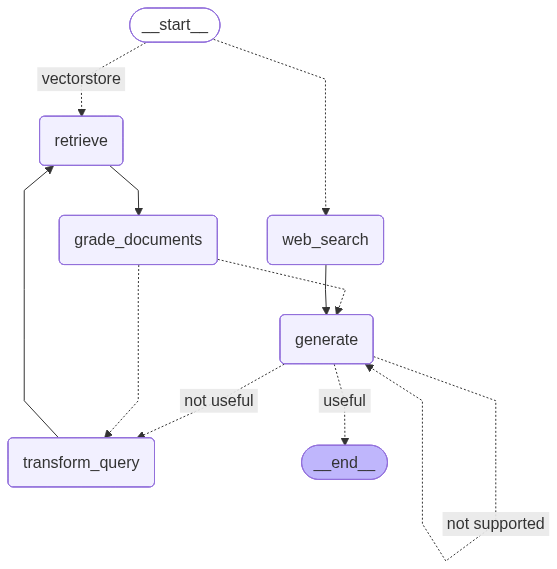

In [13]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("Graph structure is still functional")

## Test Case 1: Vectorstore Query

Test with a question that should route to the vectorstore (AI/ML topic).

In [14]:
# Question about AI/ML - should route to vectorstore
inputs = {"question": "What is machine learning and how does it work?"}

result = app.invoke(inputs)

print("\n" + "="*60)
print("FINAL RESULT")
print("="*60)
print(f"\nQuestion: {result['question']}")
print(f"\nAnswer:\n{result['generation']}")
print(f"\nNumber of documents used: {len(result['documents'])}")

---ROUTE QUESTION---
---ROUTE TO VECTORSTORE---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE---
---GRADE: RELEVANT---
---GRADE: RELEVANT---
---GRADE: RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DOCS AVAILABLE, GENERATE---
---GENERATE---
---CHECK HALLUCINATIONS---
---GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---ADDRESSES QUESTION---

FINAL RESULT

Question: What is machine learning and how does it work?

Answer:
Machine learning (ML) is a field of study in artificial intelligence that involves the development of statistical algorithms that can learn from data and generalize to unseen data, allowing them to perform tasks without explicit instructions. It works by using statistical algorithms, such as neural networks, to analyze data and make predictions or decisions, with the goal of improving performance over time. The foundations of ML are based on statistics and mathematical optimization methods.

Number of documents used: 3


## Test Case 2: Web Search Query

Test with a question requiring current information (should route to web search).

In [17]:
# Current events question - should route to web search
inputs = {"question": "What are the latest developments in quantum computing this year?"}

result = app.invoke(inputs)

print("\n" + "="*60)
print("FINAL RESULT")
print("="*60)
print(f"\nQuestion: {result['question']}")
print(f"\nAnswer:\n{result['generation']}")

---ROUTE QUESTION---
---ROUTE TO WEB SEARCH---
---WEB SEARCH---
---GENERATE---
---CHECK HALLUCINATIONS---
---GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DOES NOT ADDRESS QUESTION---
---TRANSFORM QUERY---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE---
---GRADE: NOT RELEVANT---
---GRADE: NOT RELEVANT---
---GRADE: NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---NO RELEVANT DOCS, TRANSFORM QUERY---
---TRANSFORM QUERY---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE---
---GRADE: NOT RELEVANT---
---GRADE: NOT RELEVANT---
---GRADE: NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---NO RELEVANT DOCS, TRANSFORM QUERY---
---TRANSFORM QUERY---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE---
---GRADE: NOT RELEVANT---
---GRADE: NOT RELEVANT---
---GRADE: NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---NO RELEVANT DOCS, TRANSFORM QUERY---
---TRANSFORM QUERY---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE---
---GRADE: NOT RELEVANT---
---GRADE: NOT RELEVANT---
---GRADE: NOT RELEVANT---
---AS

## Test Case 3: Complex Query with Transformation

Test with an ambiguous query that may require transformation for better retrieval.

In [19]:
# Vague question that may need transformation
inputs = {"question": "How do neural networks learn things?"}

result = app.invoke(inputs)

print("\n" + "="*60)
print("FINAL RESULT")
print("="*60)
print(f"\nOriginal Question: How do neural networks learn things?")
print(f"\nFinal Question (after any transformations): {result['question']}")
print(f"\nAnswer:\n{result['generation']}")

---ROUTE QUESTION---
---ROUTE TO VECTORSTORE---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE---
---GRADE: RELEVANT---
---GRADE: RELEVANT---
---GRADE: RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DOCS AVAILABLE, GENERATE---
---GENERATE---
---CHECK HALLUCINATIONS---
---GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DOES NOT ADDRESS QUESTION---
---TRANSFORM QUERY---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE---
---GRADE: RELEVANT---
---GRADE: RELEVANT---
---GRADE: RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DOCS AVAILABLE, GENERATE---
---GENERATE---
---CHECK HALLUCINATIONS---


RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.3-70b-versatile` in organization `org_01kbammze1e3a8dqwqf652gz64` service tier `on_demand` on tokens per day (TPD): Limit 100000, Used 100000, Requested 1000. Please try again in 14m24s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

## Key Takeaways

This Adaptive RAG implementation demonstrates several LangGraph v1.x patterns:

1. **StateGraph with TypedDict**: Clean state management with type safety
2. **Conditional Edges**: Dynamic routing based on LLM decisions
3. **Structured Outputs**: Pydantic models ensure reliable LLM responses
4. **Self-Correction Loops**: Query transformation and regeneration cycles
5. **Multi-Stage Validation**: Hallucination and answer quality checks

The workflow adapts its strategy based on:
- Query type (vectorstore vs web search)
- Document relevance scores
- Answer quality metrics

This creates a robust RAG system that handles various query types and self-corrects when needed.